In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [3]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

In [4]:
#@save
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    # voc_dir = d2l.download_extract('voc2012', os.path.join(
    #     'VOCdevkit', 'VOC2012'))
    voc_dir = "VOCdevkit/VOC2012"
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

In [5]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [6]:
#@save
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [7]:
# 预处理
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# 1. 定义一个简单的FCN网络
class SimpleFCN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 使用预训练的ResNet作为backbone
        self.backbone = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # 去掉全连接层
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        # 上采样到输入大小
        x = nn.functional.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x
# 2. 像素准确率计算
def pixel_accuracy(y_pred, y_true, ignore_index=255):
    mask = (y_true != ignore_index)
    correct = (y_pred == y_true) & mask
    acc = correct.sum().float() / mask.sum().float()
    return acc.item()

# 3. 可视化函数
def label2rgb(label, colormap=VOC_COLORMAP):
    """将类别索引mask转为RGB图片"""
    h, w = label.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for idx, color in enumerate(colormap):
        rgb[label == idx] = color
    return rgb

def show_img_and_pred(img_tensor, pred_mask, gt_mask=None):
    """img_tensor: [3,H,W]，pred_mask: [H,W]，gt_mask可选"""
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) # 反归一化
    img = np.clip(img, 0, 1)
    pred_rgb = label2rgb(pred_mask.cpu().numpy())
    if gt_mask is not None:
        gt_rgb = label2rgb(gt_mask.cpu().numpy())
        fig, axs = plt.subplots(1, 3, figsize=(12,4))
        axs[0].imshow(img)
        axs[0].set_title('Image')
        axs[1].imshow(gt_rgb)
        axs[1].set_title('Ground Truth')
        axs[2].imshow(pred_rgb)
        axs[2].set_title('Prediction')
        for ax in axs: ax.axis('off')
        plt.show()
    else:
        fig, axs = plt.subplots(1, 2, figsize=(8,4))
        axs[0].imshow(img)
        axs[0].set_title('Image')
        axs[1].imshow(pred_rgb)
        axs[1].set_title('Prediction')
        for ax in axs: ax.axis('off')
        plt.show()
# 4. 训练函数
def train_model(net, train_iter, num_epochs, device):
    net.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        net.train()
        total_loss = 0
        total_acc = 0
        num_batches = 0
        for X, Y in train_iter:
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            outputs = net(X)
            loss = criterion(outputs, Y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = outputs.argmax(1)
            total_acc += pixel_accuracy(preds, Y)
            num_batches += 1
        print(f"epoch {epoch+1}, loss {total_loss/num_batches:.4f}, pixel acc {total_acc/num_batches:.4f}")

# 5. 测试与可视化
def predict_and_visualize(net, test_iter, device, num_show=3):
    net.eval()
    shown = 0
    with torch.no_grad():
        for X, Y in test_iter:
            X, Y = X.to(device), Y.to(device)
            outputs = net(X)
            preds = outputs.argmax(1)
            for i in range(X.shape[0]):
                if shown < num_show:
                    show_img_and_pred(X[i], preds[i], Y[i])
                    shown += 1
            if shown >= num_show:
                break

In [9]:
batch_size = 16
crop_size = (320, 480)
train_iter, test_iter = load_data_voc(batch_size, crop_size)
num_classes = len(VOC_CLASSES)

read 1114 examples
read 1078 examples


epoch 1, loss 1.2142, pixel acc 0.7324
epoch 2, loss 0.8603, pixel acc 0.7672
epoch 3, loss 0.7747, pixel acc 0.7812
epoch 4, loss 0.7037, pixel acc 0.7900
epoch 5, loss 0.6200, pixel acc 0.8133
epoch 6, loss 0.5822, pixel acc 0.8186
epoch 7, loss 0.5426, pixel acc 0.8274
epoch 8, loss 0.4773, pixel acc 0.8464
epoch 9, loss 0.4235, pixel acc 0.8601
epoch 10, loss 0.3798, pixel acc 0.8752
epoch 11, loss 0.3611, pixel acc 0.8801
epoch 12, loss 0.3290, pixel acc 0.8885
epoch 13, loss 0.3159, pixel acc 0.8921
epoch 14, loss 0.2743, pixel acc 0.9058
epoch 15, loss 0.2262, pixel acc 0.9212
epoch 16, loss 0.2743, pixel acc 0.9055
epoch 17, loss 0.2889, pixel acc 0.9025
epoch 18, loss 0.2383, pixel acc 0.9174
epoch 19, loss 0.2103, pixel acc 0.9252
epoch 20, loss 0.1871, pixel acc 0.9325
epoch 21, loss 0.1718, pixel acc 0.9372
epoch 22, loss 0.1584, pixel acc 0.9423
epoch 23, loss 0.1394, pixel acc 0.9472
epoch 24, loss 0.1307, pixel acc 0.9501
epoch 25, loss 0.1250, pixel acc 0.9519


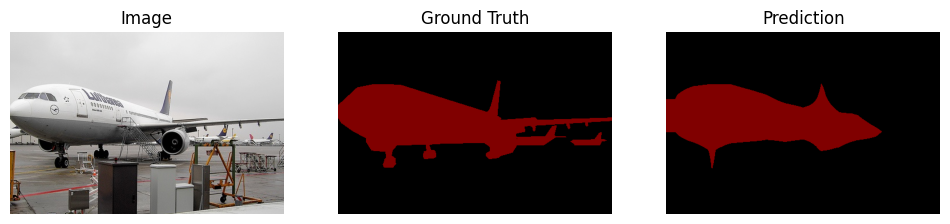

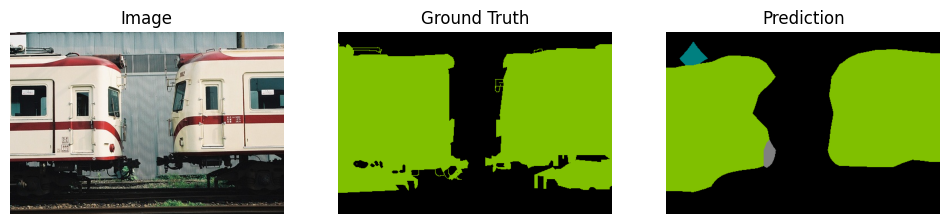

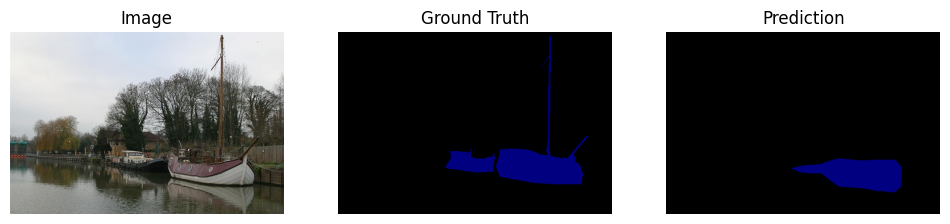

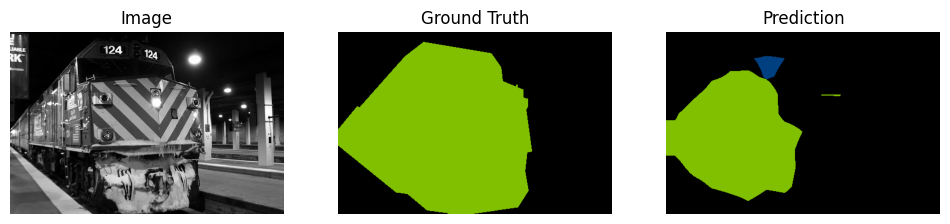

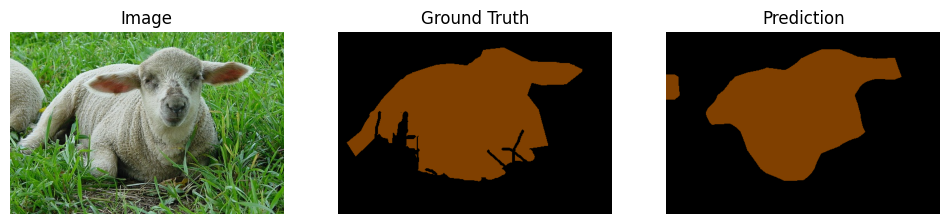

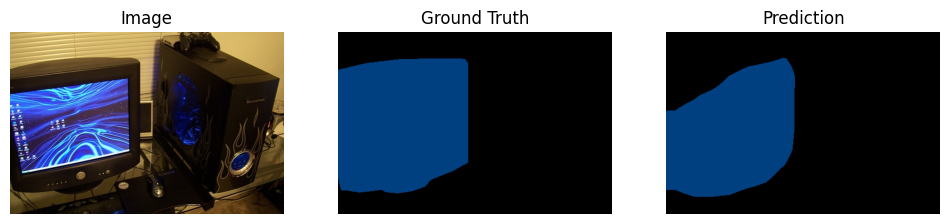

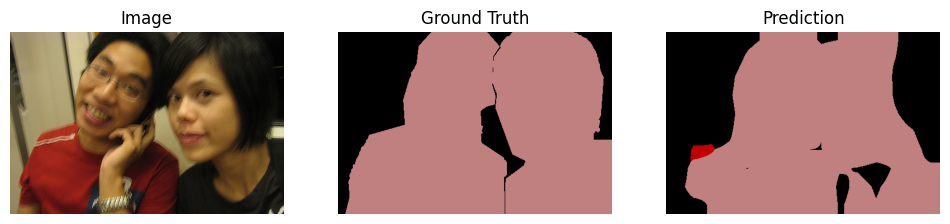

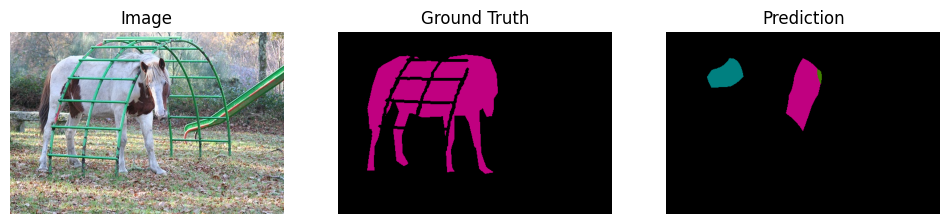

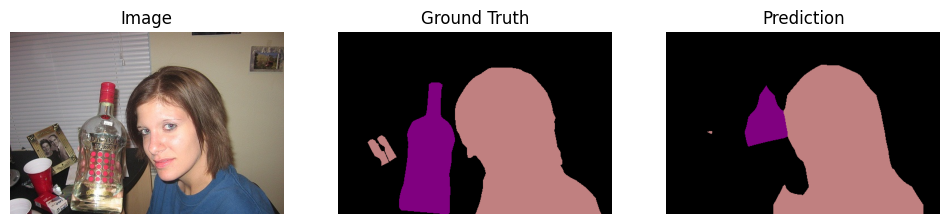

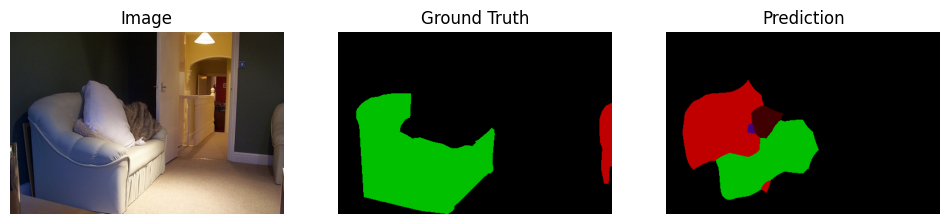

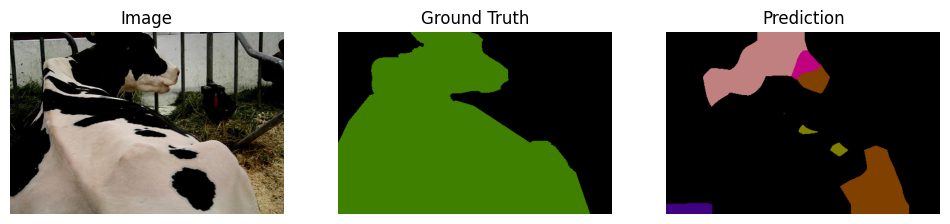

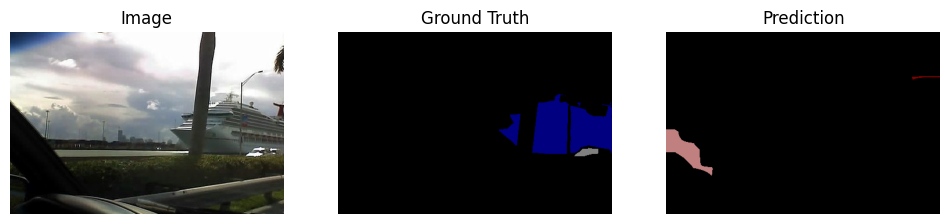

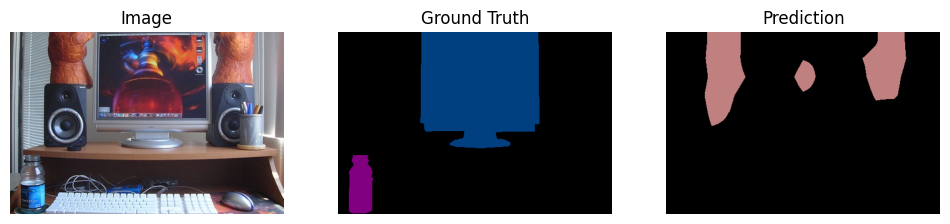

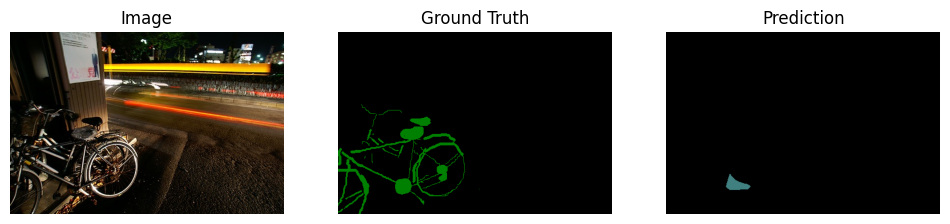

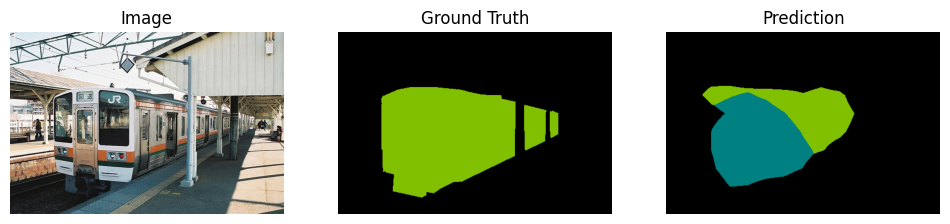

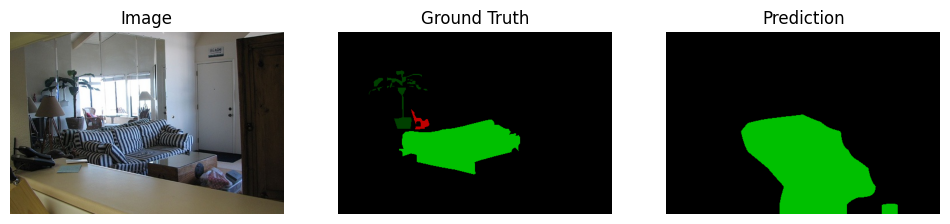

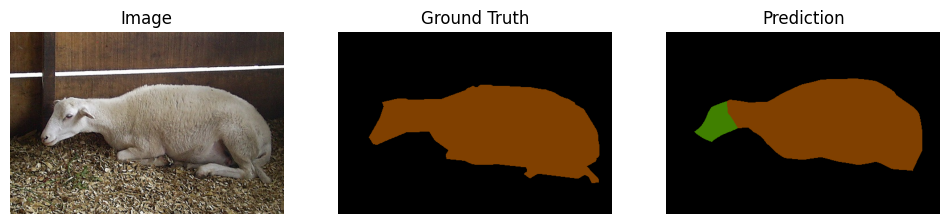

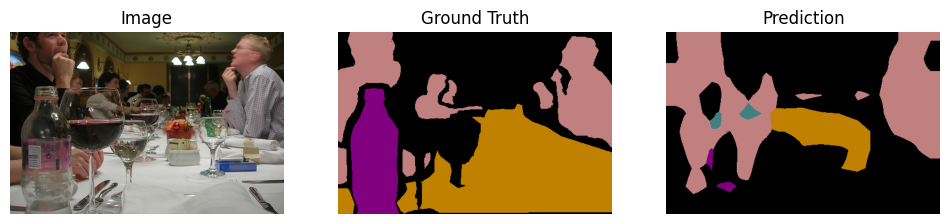

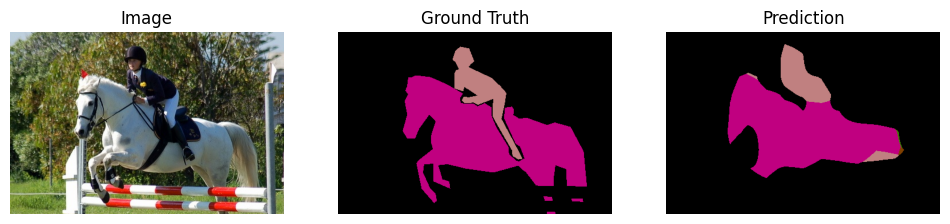

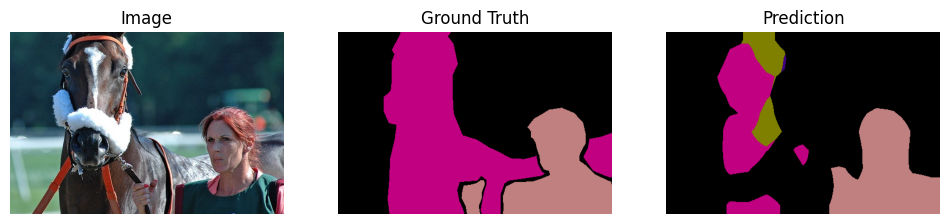

In [13]:
# 6. 运行训练和可视化
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(VOC_CLASSES)
net = SimpleFCN(num_classes)
train_model(net, train_iter, num_epochs=25, device=device)
predict_and_visualize(net, test_iter, device=device, num_show=20)

epoch 1, loss 1.8672, pixel acc 0.6736
epoch 2, loss 1.3277, pixel acc 0.7257
epoch 3, loss 1.2853, pixel acc 0.7282
epoch 4, loss 1.2685, pixel acc 0.7264
epoch 5, loss 1.2445, pixel acc 0.7271


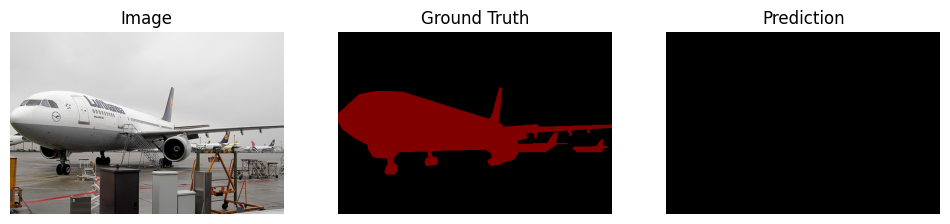

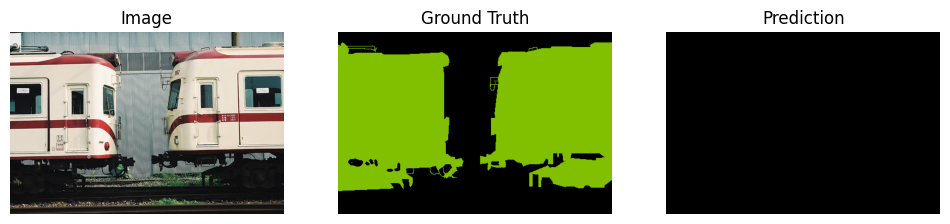

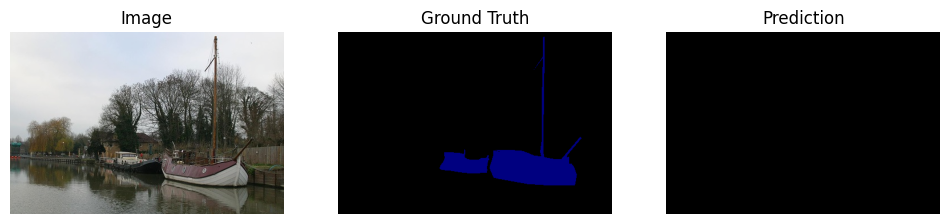

In [11]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt

# # UNet基础模块
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.seq = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
#     def forward(self, x):
#         return self.seq(x)

# class UNet(nn.Module):
#     def __init__(self, num_classes, in_channels=3, features=[64, 128, 256, 512]):
#         super().__init__()
#         self.downs = nn.ModuleList()
#         self.ups = nn.ModuleList()
#         # 下采样部分
#         for feature in features:
#             self.downs.append(DoubleConv(in_channels, feature))
#             in_channels = feature
#         # 上采样部分
#         for feature in reversed(features):
#             self.ups.append(
#                 nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
#             )
#             self.ups.append(DoubleConv(feature*2, feature))
#         self.bottleneck = DoubleConv(features[-1], features[-1]*2)
#         self.final_conv = nn.Conv2d(features[0], num_classes, kernel_size=1)

#         self.pool = nn.MaxPool2d(2, 2)

#     def forward(self, x):
#         skip_connections = []
#         for down in self.downs:
#             x = down(x)
#             skip_connections.append(x)
#             x = self.pool(x)
#         x = self.bottleneck(x)
#         skip_connections = skip_connections[::-1]
#         for idx in range(0, len(self.ups), 2):
#             x = self.ups[idx](x)
#             skip_connection = skip_connections[idx//2]
#             # 处理尺寸不一致
#             if x.shape != skip_connection.shape:
#                 x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
#             x = torch.cat((skip_connection, x), dim=1)
#             x = self.ups[idx+1](x)
#         return self.final_conv(x)

# # 像素准确率
# def pixel_accuracy(y_pred, y_true, ignore_index=255):
#     mask = (y_true != ignore_index)
#     correct = (y_pred == y_true) & mask
#     acc = correct.sum().float() / mask.sum().float()
#     return acc.item()

# # mask转RGB
# def label2rgb(label, colormap=VOC_COLORMAP):
#     h, w = label.shape
#     rgb = np.zeros((h, w, 3), dtype=np.uint8)
#     for idx, color in enumerate(colormap):
#         rgb[label == idx] = color
#     return rgb

# def show_img_and_pred(img_tensor, pred_mask, gt_mask=None):
#     img = img_tensor.permute(1,2,0).cpu().numpy()
#     img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
#     img = np.clip(img, 0, 1)
#     pred_rgb = label2rgb(pred_mask.cpu().numpy())
#     if gt_mask is not None:
#         gt_rgb = label2rgb(gt_mask.cpu().numpy())
#         fig, axs = plt.subplots(1, 3, figsize=(12,4))
#         axs[0].imshow(img)
#         axs[0].set_title('Image')
#         axs[1].imshow(gt_rgb)
#         axs[1].set_title('Ground Truth')
#         axs[2].imshow(pred_rgb)
#         axs[2].set_title('Prediction')
#         for ax in axs: ax.axis('off')
#         plt.show()
#     else:
#         fig, axs = plt.subplots(1, 2, figsize=(8,4))
#         axs[0].imshow(img)
#         axs[0].set_title('Image')
#         axs[1].imshow(pred_rgb)
#         axs[1].set_title('Prediction')
#         for ax in axs: ax.axis('off')
#         plt.show()

# # 训练
# def train_model(net, train_iter, num_epochs, device):
#     net.to(device)
#     criterion = nn.CrossEntropyLoss(ignore_index=255)
#     optimizer = optim.Adam(net.parameters(), lr=1e-3)
#     for epoch in range(num_epochs):
#         net.train()
#         total_loss = 0
#         total_acc = 0
#         num_batches = 0
#         for X, Y in train_iter:
#             X, Y = X.to(device), Y.to(device)
#             optimizer.zero_grad()
#             outputs = net(X)
#             # outputs: [B, num_classes, H, W], Y: [B, H, W]
#             loss = criterion(outputs, Y)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#             preds = outputs.argmax(1)
#             total_acc += pixel_accuracy(preds, Y)
#             num_batches += 1
#         print(f"epoch {epoch+1}, loss {total_loss/num_batches:.4f}, pixel acc {total_acc/num_batches:.4f}")

# # 测试与可视化
# def predict_and_visualize(net, test_iter, device, num_show=3):
#     net.eval()
#     shown = 0
#     with torch.no_grad():
#         for X, Y in test_iter:
#             X, Y = X.to(device), Y.to(device)
#             outputs = net(X)
#             preds = outputs.argmax(1)
#             for i in range(X.shape[0]):
#                 if shown < num_show:
#                     show_img_and_pred(X[i], preds[i], Y[i])
#                     shown += 1
#             if shown >= num_show:
#                 break

# # 运行
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# num_classes = len(VOC_CLASSES)
# net = UNet(num_classes)
# train_model(net, train_iter, num_epochs=5, device=device)
# predict_and_visualize(net, test_iter, device=device, num_show=3)